# COMP90051 Project 2
**Name:** Diego Alejandro Arias Rodriguez

**Student ID:** 1057230

In [16]:
# First import all the necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from collections import Counter
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

 #Sklearn imports:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from scipy.stats import entropy

## 0. Loading the dataset

In [17]:
# do not edit this cell
# load the data files
embedded_images = np.load('images.npy')
labels = np.load('labels.npy')

# split into pool & testing
X_pool, X_test, y_pool, y_test = train_test_split(embedded_images, labels, 
                                                  test_size=0.5, random_state=1234, shuffle=True)

# sample a seed set
np.random.seed(1234)
label2id = defaultdict(list)
for i, label in enumerate(y_pool):
    label2id[label].append(i)
seed_set = []
for label, ids in label2id.items():
    seed_set.extend(np.random.choice(ids, size=10, replace=False))

## 1. Applying logistic regression

#### First, I used Logistic Regression classifier and performed a gridsearch to find the best parameters, which turned out to be:
#### Solver: lbfgs, max iterations: 250 and penalty:None. Please do not runthis sell unless you are interested in verifying it because it will take a long time. 
#### I did not try other solvers because they took very long eventhough some of them converged i.e. liblinear

In [ ]:
#This Grid search was performed to find the best parameters:
from sklearn.model_selection import GridSearchCV

parameters = {'solver':['lbfgs'], 'penalty':('none','l2'), 'max_iter':[100,250,300]}
logr=LogisticRegression()
clf=GridSearchCV(logr, parameters, cv=5)

clf.fit(X_pool, y_pool)

sorted(clf.cv_results_.keys())

pd.DataFrame(clf.cv_results_)

In [26]:
def train_logistic_regression(X, y, **args):
    """
    Train a logistic regression model on dataset (X, y) and return trained model.
    X: matrix of real values, size n x d
    y: vector of string labels, size n
    args: optional arguments e.g., for hyper-parameters
    """
    # Here I use the hyperparameters that I found in the grid Search cv
    lr = LogisticRegression(random_state=1234, solver='lbfgs', max_iter=250, penalty='none').fit(X, y)
    
    return lr

In [25]:
def evaluate_logistic_regression_accuracy(Xt, yt, model):
    """
    Apply logistic regression prediction on dataset Xt and evaluate accuracy against yt,
    returing the accuracy results as a scalar.
    Xt: matrix of real values, size m x d
    yt: vector of string labels, size m
    """
    y_pred= model.predict(Xt)
    
    return accuracy_score(yt, y_pred)

In [22]:
%%time
# Code for training, evaluating & plotting results
lr=train_logistic_regression(X_pool, y_pool)

acc=evaluate_logistic_regression_accuracy(X_test, y_test, lr)

print("Test accuracy: ",acc)

Test accuracy:  0.5719917012448132
Wall time: 7.19 s


## 2. Active learning framework with Random selection

In [24]:
def random_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a model (not used)
    returns a vector of scores of length n. Each entry reflects the priority 
    of the corresponding instance. Higher means better.
    """
    return np.random.rand(len(X),1).ravel()

In [27]:
def pool_based_active_learning(X_pool, y_pool, seed_ids,
                               train_func, select_func,
                               max_size, batch_size, **args):
    """
    Perform an active learning simulation, which starts by training on a seed set,
    then iteratively applies the selection function to rank instances in the pool,
    selects the top few instances which are included into the training set and the
    process repeats. 
        X_pool: matrix of n x d
        y_pool: vector of string labels, size n
        seed_ids: initial labelled set set, as a list of indices [0..n-1] into pool
        train_func: function which given (X, y, optional args) returns a trained model
        select_func: function which given (X, optional args) returns a sequence of scores
        max_size: stopping condition for active learning, when labelled data reaches given size
        batch_size: number of instances to be labelled in each iteration
        args: optional arguments passed to training and selection function
    returns the sequence of trained models 
    """
    
    known=seed_set.copy()
    
    #Subset of instances with known labels
    L=[X_pool[index] for index in known] 
    L_lab= [y_pool[index] for index in known] #
    
    #Subset of instances with unknown labels
    U=[X_pool[i] for i, data in enumerate(X_pool) if i not in known]
    U_lab=[y_pool[i] for i, data in enumerate(y_pool) if i not in known]

    
    trained_models=[]

    while len(L)<max_size:

        model=train_func(L,L_lab)
        
        if type(model)==tuple:
            trained_models.append(model[1])
            scored=select_func(U, model[0])
        else:
            trained_models.append(model)
            scored=select_func(U, model)     

        #Selects the n top instances to query according to the selection function
        data={'score':scored}
        selected= pd.DataFrame(data)
        selected=selected.sort_values(by=['score'],axis=0, ascending=False)
        selected=selected.reset_index()
        selected_indexes=selected['index'][:batch_size].tolist()
        
        #Updates L set
        for i in selected_indexes:
            L.append(U[i])
            L_lab.append(U_lab[i])
            
        #Updates U set
        U=[inst for i,inst in enumerate(U) if i not in selected_indexes]
        U_lab=[lab_inst for i,lab_inst in enumerate(U_lab) if i not in selected_indexes]
        
    model=train_func(L,L_lab)
    
    if type(model)==tuple:
        trained_models.append(model[1])
    else:
        trained_models.append(model)
        
#     print("len u after is:", len(U), len(U_lab))
#     print("len l after is:", len(L), len(L_lab))

    return trained_models

In [28]:
# Run the active learning framework with a random selection querying criteria
batch = 60
max_size = 3000
models_random = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_logistic_regression, random_select, 
                                    max_size, batch)

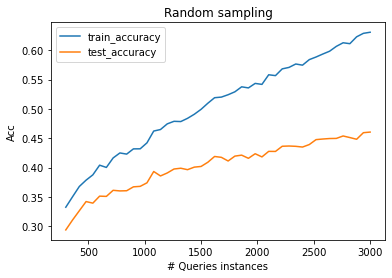

In [31]:
## Evaluation of accuracy and plotting of results of random sampling
train_acc_list_r=[]
test_acc_list_r=[]

for model in models_random:
    train_acc_list_r.append(evaluate_logistic_regression_accuracy(X_pool,y_pool,model))
    test_acc_list_r.append(evaluate_logistic_regression_accuracy(X_test,y_test,model))


    
x=np.arange(300,3001,60)

plt.plot(x, train_acc_list_r,label='train_accuracy')
plt.plot(x, test_acc_list_r,label='test_accuracy')
plt.title('Random sampling')
plt.xlabel("# Queries instances")
plt.ylabel("Acc")
plt.legend()
plt.show()

## 3. Uncertainty sampling

In [33]:
def logistic_regression_entropy_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values.
    """
    preds=model.predict_proba(X)
    entropies=[]
    
    for probs in preds:
        entrop= entropy(probs)
        entropies.append(entrop)
        
    return entropies

In [34]:
# Run the active learning framework with a random selection querying criteria
models_us = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_logistic_regression,
                                 logistic_regression_entropy_select, 
                                 max_size, batch)

46


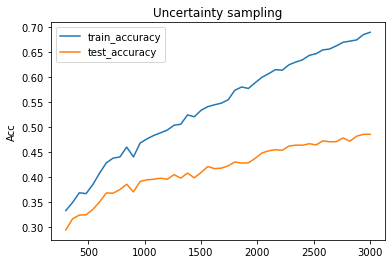

In [35]:
## Evaluation of accuracy and plotting of results of uncertainty sampling
train_acc_list_us=[]
test_acc_list_us=[]

for model in models_us:
    train_acc_list_us.append(evaluate_logistic_regression_accuracy(X_pool,y_pool,model))
    test_acc_list_us.append(evaluate_logistic_regression_accuracy(X_test,y_test,model))

x=np.arange(300,3001,60)

plt.plot(x, train_acc_list_us,label='train_accuracy')
plt.plot(x, test_acc_list_us,label='test_accuracy')
plt.title('Uncertainty sampling')
plt.ylabel("Acc")
plt.legend()
plt.show()

## 4. Query by committee

In [36]:
def query_by_committee_vote_entropy(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values using query_by_committee vote entropy criteria.
    """
    
    committee=model.estimators_ #Classifiers in the ensemble
    C=len(model.estimators_) #Number of classifiers in the ensemble
    
    #Zips and creates matrix nxC. n=number of instances, C=number of estimators in the committee
    pred_list=[estim.predict(X) for estim in committee]
    zip_preds=list(zip(*pred_list))
    preds_join=[list(instance) for instance in zip_preds]
    
    #Calculates the entropies for every instance
    entropies=[]
    for votes in preds_join:
        counts=np.array(list(Counter(votes).values()))
        probs=np.divide(counts,C)
        entrop= entropy(probs)
        entropies.append(entrop)
    
    return entropies

def query_by_committee_soft_vote_entropy(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values using query_by_committee soft vote entropy criteria.
    """
    
    committee=model.estimators_ #Classifiers in the ensemble
    C=len(model.estimators_) #Number of classifiers in the ensemble
    
    #Creates matrix CxnxY. n=number of instances, y=number of labels C=number of estimators in the committee
    pred_list=[estim.predict_proba(X) for estim in committee]
    
    #Calculates Pc(y|x)
    summed_preds=np.zeros(pred_list[0].shape)
    for predClassif in  pred_list:
        summed_preds+=predClassif
    Pcygivenx=np.divide(summed_preds,C)

    entropies=[]
    for labels in Pcygivenx:
        entrop= entropy(labels)
        entropies.append(entrop)

        verif=0
        for j in labels:
            verif+= j*np.log(j)
        verif=verif*-1

        assert abs(entrop-verif)<0.001
    return entropies
    pass

def query_by_committee_KL(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values using query_by_committee KL divergence criteria.
    """
    
    committee=model.estimators_ #Classifiers in the ensemble
    C=len(model.estimators_)    #Number of classifiers in the ensemble
    
    #Creates matrix CxnxY. n=number of instances, y=number of labels C=number of estimators in the committee
    pred_list=[estim.predict_proba(X) for estim in committee] 
    
    #Calculates Pc(y|x)
    summed_preds=np.zeros(pred_list[0].shape)
    for predClassif in  pred_list:
        summed_preds+=predClassif
    Pcygivenx=np.divide(summed_preds,C)

    aux=[]
    aux2=[]
    aux3=[]
    #Generates KL_div's for each classif
    KL_div=[]
    for preds_i in pred_list:
        a1=np.divide(preds_i,Pcygivenx) #Divides Ptheta(Y|X) by Pc(Y|X)
        aux.append(np.divide(preds_i,Pcygivenx)) #
        a2=np.log(a1)
        aux2.append(a2) #Applies natural logarithm to  Ptheta(Y|X)/Pc(Y|X)
        a3=np.multiply(preds_i,a2)
        aux3.append(a3)
        diverg_classif=[]
        for bylab in a3:
            diverg_classif.append(sum(bylab))
        KL_div.append(diverg_classif)

    
    entropies=np.zeros((len(KL_div[0]),))
    # sums over the KL divergences that were found
    for div in KL_div:

        entropies+=div

    
    return np.divide(entropies,C)
    
    pass

In [37]:
def train_committee(X, y, **args):

    committee=BaggingClassifier(base_estimator=LogisticRegression(),n_estimators=2, random_state=1234, bootstrap=True, max_samples=len(X)).fit(X, y)
    
    standard_lr=train_logistic_regression(X,y)
    print(committee)
    return (committee,standard_lr)
    pass

### First run models to improve readability of results later

In [38]:
%%time
#Runs hard voting
models_hard_vote = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_committee,
                                 query_by_committee_vote_entropy, 
                                 max_size, batch)
# Runs soft voting
models_soft_vote = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_committee,
                                 query_by_committee_soft_vote_entropy, 
                                 max_size, batch)
# Runs KL divergence
models_kl = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_committee,
                                 query_by_committee_KL, 
                                 max_size, batch)


BaggingClassifier(base_estimator=LogisticRegression(), max_samples=300,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=360,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=420,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=480,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=540,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=600,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=660,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=720,
                  n_estimators=2, random_state=1234)


BaggingClassifier(base_estimator=LogisticRegression(), max_samples=1500,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=1560,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=1620,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=1680,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=1740,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=1800,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=1860,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=1920,
                  n_estimators=2, random_stat

BaggingClassifier(base_estimator=LogisticRegression(), max_samples=2700,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=2760,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=2820,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=2880,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=2940,
                  n_estimators=2, random_state=1234)
BaggingClassifier(base_estimator=LogisticRegression(), max_samples=3000,
                  n_estimators=2, random_state=1234)
Wall time: 8min 16s


# Hardvoting

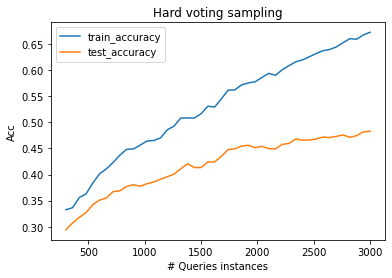

In [39]:
## Evaluation of accuracy and plotting of results of query by committee (hard voting)
train_acc_list_hard=[]
test_acc_list_hard=[]

for model in models_hard_vote:
    train_acc_list_hard.append(evaluate_logistic_regression_accuracy(X_pool,y_pool,model))
    test_acc_list_hard.append(evaluate_logistic_regression_accuracy(X_test,y_test,model))

x=np.arange(300,3001,60)

plt.plot(x, train_acc_list_hard,label='train_accuracy')
plt.plot(x, test_acc_list_hard,label='test_accuracy')
plt.title('Hard voting sampling')
plt.xlabel("# Queries instances")
plt.ylabel("Acc")
plt.legend()
plt.show()

# Softvoting

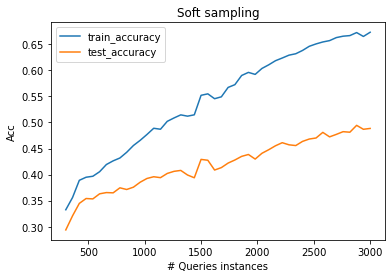

In [44]:
## Evaluation of accuracy and plotting of results of query by committee (soft voting)
train_acc_list_soft=[]
test_acc_list_soft=[]

for model in models_soft_vote:
    train_acc_list_soft.append(evaluate_logistic_regression_accuracy(X_pool,y_pool,model))
    test_acc_list_soft.append(evaluate_logistic_regression_accuracy(X_test,y_test,model))

x=np.arange(300,3001,60)

plt.plot(x, train_acc_list_soft,label='train_accuracy')
plt.plot(x, test_acc_list_soft,label='test_accuracy')
plt.title('Soft sampling')
plt.xlabel("# Queries instances")
plt.ylabel("Acc")
plt.legend()
plt.show()

# KL entropy

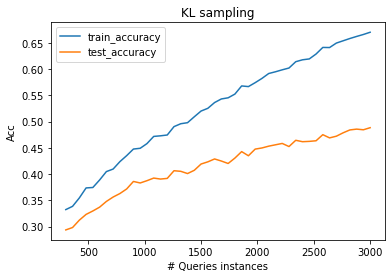

In [45]:
## Evaluation of accuracy and plotting of results of query by committee (KL divergence)
train_acc_list_KL=[]
test_acc_list_KL=[]

for model in models_kl:
    train_acc_list_KL.append(evaluate_logistic_regression_accuracy(X_pool,y_pool,model))
    test_acc_list_KL.append(evaluate_logistic_regression_accuracy(X_test,y_test,model))


x=np.arange(300,3001,60)

plt.plot(x, train_acc_list_KL,label='train_accuracy')
plt.plot(x, test_acc_list_KL,label='test_accuracy')
plt.title('KL sampling')
plt.xlabel("# Queries instances")
plt.ylabel("Acc")
plt.legend()
plt.show()

## Here we can visualize the results for the 3 committee methos altogether

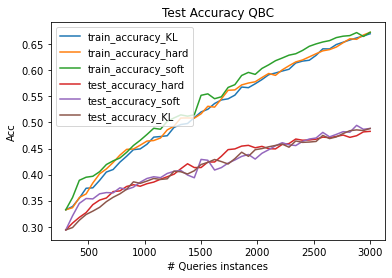

In [46]:
plt.plot(x, train_acc_list_KL,label='train_accuracy_KL')
plt.plot(x, train_acc_list_hard,label='train_accuracy_hard')
plt.plot(x, train_acc_list_soft,label='train_accuracy_soft')

plt.plot(x, test_acc_list_hard,label='test_accuracy_hard')
plt.plot(x, test_acc_list_soft,label='test_accuracy_soft')
plt.plot(x, test_acc_list_KL,label='test_accuracy_KL')
plt.title('Test Accuracy QBC')
plt.xlabel("# Queries instances")
plt.ylabel("Acc")
plt.legend()
plt.show()
